In [1]:
import pandas as pd 
import gspread 
from oauth2client.service_account import ServiceAccountCredentials
from pandas.io.json import json_normalize
from matplotlib import pyplot
from pandas.plotting import lag_plot

## Connect to Sheet

In [2]:
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('./fifth-tangent-301922-e9b71e669448.json', scope)
gc = gspread.authorize(credentials)

In [3]:
spreadsheet_key = '1mKOeKWf8f_mUmxbDQeHMA-P6lk6SfZf4Q9CRBH44EHU'
book = gc.open_by_key(spreadsheet_key)
worksheet = book.worksheet("Results_number")
table = worksheet.get_all_values()
df = pd.DataFrame(table[3:], columns=table[2])
df_raw_data = df.drop(["SampleID","ManholeID","Building(s)"],axis=1)
df_raw_data = df_raw_data.drop(df.tail(1).index)
df_raw_data = df_raw_data.fillna(0)
df_raw_data = df_raw_data.replace("",0)
df_raw_data = df_raw_data.replace("ND",0)
df_raw_data = df_raw_data.astype(float)

In [4]:
positive_count = (df_raw_data>0).sum(axis=0)
positive_count[:-5]

11/23    11
11/24     8
11/25    11
11/26     9
11/27    12
11/28    13
11/29    12
11/30    14
12/1     19
12/2     25
12/3     22
12/4     25
12/5     19
12/6     19
12/7     21
12/8     17
12/9     18
12/10    20
12/11    19
12/12    20
12/13    19
12/14    24
12/15    21
12/16    27
12/17    16
12/18    18
12/19    20
12/20    19
12/21    16
12/22    23
         ..
1/1      24
1/2      21
1/3      26
1/4      29
1/5      39
1/6      43
1/7      39
1/8      34
1/9      42
1/10     37
1/11     39
1/12     36
1/13     36
1/14     38
1/15     35
1/16     45
1/17     44
1/18     41
1/19     32
1/20     33
1/21     31
1/22     35
1/23     34
1/24     27
1/25     27
1/26     33
1/27     30
1/28     33
1/29     41
1/30     26
Length: 69, dtype: int64

## Autocorrelation detection

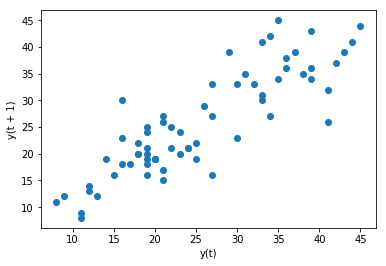

In [5]:
lag_plot(positive_count[:-5])
pyplot.show()

In [162]:
values = pd.DataFrame(positive_count[:-5])
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
result

,t-1,t+1
t-1,1.000000,0.865166
t+1,0.865166,1.000000


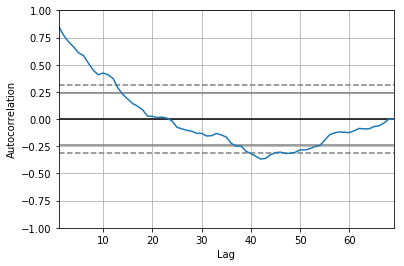

In [7]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(positive_count[:-5])

In [8]:
! pip install statsmodels --upgrade
! pip install numpy --upgrade

Requirement already up-to-date: statsmodels in /Users/yijianzong/anaconda3/lib/python3.7/site-packages (0.12.1)
You are using pip version 19.0.1, however version 21.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: numpy in /Users/yijianzong/anaconda3/lib/python3.7/site-packages (1.20.0)
You are using pip version 19.0.1, however version 21.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


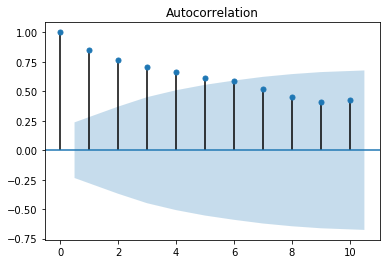

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(positive_count[:-5], lags=10)
pyplot.show()

### Conclusion: 1-2 days give the best offsets

Test MSE: 56.000


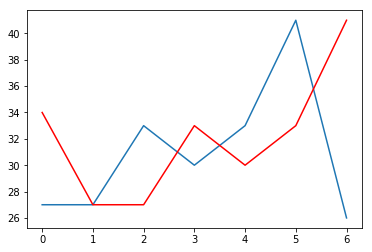

In [15]:
# create lagged dataset
values = pd.DataFrame(positive_count[:-5])
dataframe = pd.concat([values.shift(1), values], axis=1)
from sklearn.metrics import mean_squared_error
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test:
    predictions.append(x[0])
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Coefficients: [3.29961803 0.88114887]
predicted=33.258680, expected=27.000000
predicted=32.605466, expected=27.000000
predicted=32.029887, expected=33.000000
predicted=31.522717, expected=30.000000
predicted=31.075824, expected=33.000000
predicted=30.682045, expected=41.000000
predicted=30.335068, expected=26.000000
Test RMSE: 5.383


/Users/yijianzong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


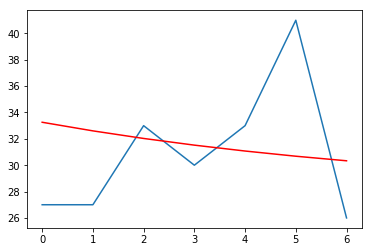

In [269]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
train, test = positive_count[:-5].values[:len(X)-7], positive_count[:-5].values[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

[35 34]
[35, 34]
predicted=33.810118, expected=27.000000
predicted=29.014495, expected=27.000000
predicted=27.301596, expected=33.000000
predicted=31.202387, expected=30.000000
predicted=30.720191, expected=33.000000
predicted=31.936487, expected=41.000000
predicted=37.871641, expected=26.000000
Test RMSE: 6.683


/Users/yijianzong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


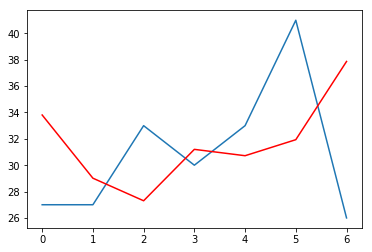

In [278]:
# split dataset
X = positive_count[:-5].values
train, test = X[:len(X)-7], X[len(X)-7:]
# train autoregression
window = 2
model = AutoReg(train, lags=window)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
print(history)
history = [history[i] for i in range(len(history))]
print(history)
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [62]:
def getRMSE(window,train,test):
    model = AutoReg(train, lags=window)
    model_fit = model.fit()
    coef = model_fit.params
    # walk forward over time steps in test
    history = train[len(train)-window:]
    print(history)
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    return rmse

In [63]:
"""
Test RMSE: 7.021
Test RMSE: 6.937

"""

'\nTest RMSE: 7.021\nTest RMSE: 6.937\n\n'

In [65]:
windows = list(range(11))
[getRMSE(window,train,test) for window in windows]

[]
Test RMSE: 7.930
[34]
Test RMSE: 7.021
[35 34]
Test RMSE: 6.683
[31 35 34]
Test RMSE: 6.575
[33 31 35 34]
Test RMSE: 6.893
[32 33 31 35 34]
Test RMSE: 6.937
[41 32 33 31 35 34]
Test RMSE: 6.867
[44 41 32 33 31 35 34]
Test RMSE: 6.844
[45 44 41 32 33 31 35 34]
Test RMSE: 6.755
[35 45 44 41 32 33 31 35 34]
Test RMSE: 6.913
[38 35 45 44 41 32 33 31 35 34]
Test RMSE: 7.077


/Users/yijianzong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


[7.929543316126031,
 7.0208113009274316,
 6.682964504719611,
 6.575224864931743,
 6.893449297576908,
 6.9369308990721095,
 6.866577398132709,
 6.844396036158616,
 6.754935402334594,
 6.912714684673939,
 7.076718778084781]

## Group by buildings

In [129]:
df_raw_bdata = df.drop(["SampleID","ManholeID"],axis=1)

In [130]:
df_raw_bdata = df_raw_bdata.drop(df.tail(8).index)
df_raw_bdata = df_raw_bdata.iloc[:, :-5]
df_raw_bdata.iloc[:,1:] = df_raw_bdata.iloc[:,1:].fillna(0).replace("",0).replace("ND",0).astype(float)

In [154]:
cases_by_build = df_raw_bdata.groupby("Building(s)")[df_raw_bdata.columns[1:]].apply(lambda x: (x > 0).sum())

In [155]:
cases_by_build

,11/23,11/24,11/25,11/26,11/27,11/28,11/29,11/30,12/1,12/2,...,1/21,1/22,1/23,1/24,1/25,1/26,1/27,1/28,1/29,1/30
Building(s),,,,,,,,,,,,,,,,,,,,,
Appl. Physics and Math,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRF2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
Biology,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
Biology field Station,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,1,0
"Blake, Argo, Urey",0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,1,1
Camp Snoopy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Central and South Mesa,3,2,0,0,0,0,0,0,3,4,...,7,6,7,3,4,3,3,5,5,3
Coast apartments,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
Corallina west Birch aquarium,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [291]:
cases_by_build.sum(axis=1).sort_values(ascending=False)

Building(s)
Central and South Mesa           279
Marshall:Lower and Upper         139
Seventh                          135
NUEVO EAST (ISOLATION)           116
Revelle                          111
ERC                               91
Marshall                          76
Nuevo East Piedra                 68
Warren                            67
One Miramar                       66
Pepper Canyon                     64
Tamarack - Muir APT               53
Tuolumne - Muir APT               53
NTPLLN- Kaleidoscope              42
Mesa Nueva: Cala                  37
Coast apartments                  35
Rita Atkinson Residences          34
NTPLLN- Catalyst                  30
Nuevo West: Viento                27
Nuevo West: Brisa                 24
Mesa Nueva:Cresta                 22
Tenaya - Muir RH                  22
Blake, Argo, Urey                 18
Camp Snoopy                       13
Pepper Canyon 1200,1800           10
Neural Behavior                    7
Medical Teaching Facility 

In [212]:
results = []
for building_name in cases_by_build.index:
    values_app = pd.DataFrame(cases_by_build.loc[building_name])
    dataframe = pd.concat([values_app.shift(1), values_app], axis=1)
    dataframe.columns = ['t-1', 't+1']
    result = dataframe.corr()['t-1']['t+1']
    results.append((0 if np.isnan(result) else result,building_name))
    print(result,building_name)

nan Appl. Physics and Math
-0.014925373134328365 BRF2
-0.030303030303030325 Biology
0.46875 Biology field Station
0.42339019740572603 Blake, Argo, Urey
0.09171861086375768 Camp Snoopy
0.7011221945137158 Central and South Mesa
0.4269058364641294 Coast apartments
-0.014925373134328363 Corallina west Birch aquarium
nan Deep Sea Drilling
0.23971377459749557 ERC
nan Fred N. Spiess Hall
nan Hubbs South
nan Isaacs Hall
nan Jacob's Hall
0.40849122311878305 Jacob's Retinal
-0.014925373134328365 Keck
nan Keck OAR combined 1,3 West
nan MESOM south/east
0.6030595813204516 Marshall
0.48593917622690497 Marshall:Lower and Upper
0.45161290322580655 Medical Teaching Facility
-0.0554323725055432 Mesa Nueva
0.11072362685265913 Mesa Nueva: Cala
0.5968379446640316 Mesa Nueva:Cresta
0.34385964912280714 NTPLLN- Catalyst
0.6263736263736259 NTPLLN- Kaleidoscope 
0.3025641025641027 NTPLLN- Tapestry
0.6684801701619112 NUEVO EAST (ISOLATION)
0.6814988290398127 Neural Behavior
nan Nierenberg Hall
-0.01492537313432

In [215]:
results.sort(reverse=True)
results

[(0.9112218859414871, 'Revelle'),
 (0.7636262513904337, 'Pepper Canyon'),
 (0.7406936626112217, 'Warren'),
 (0.7011221945137158, 'Central and South Mesa'),
 (0.6814988290398127, 'Neural Behavior'),
 (0.6684801701619112, 'NUEVO EAST (ISOLATION)'),
 (0.6263736263736259, 'NTPLLN- Kaleidoscope '),
 (0.6030595813204516, 'Marshall'),
 (0.5968379446640316, 'Mesa Nueva:Cresta'),
 (0.5280004212304212, 'Seventh'),
 (0.5083027993146316, 'York Hall'),
 (0.49028346578852783, 'Tenaya - Muir RH'),
 (0.48593917622690497, 'Marshall:Lower and Upper'),
 (0.4848484848484848, 'Novel therapeutics'),
 (0.46875, 'Biology field Station'),
 (0.45161290322580655, 'Medical Teaching Facility'),
 (0.4269058364641294, 'Coast apartments'),
 (0.42339019740572603, 'Blake, Argo, Urey'),
 (0.40849122311878305, "Jacob's Retinal"),
 (0.4033740517248997, 'One Miramar'),
 (0.34615384615384515, 'Tuolumne - Muir APT'),
 (0.34385964912280714, 'NTPLLN- Catalyst'),
 (0.3025641025641027, 'NTPLLN- Tapestry'),
 (0.30256410256410254,

## Build Autoregression model on buildings with correlation > 0.7

In [183]:
above7 = results[-4:]

In [188]:
windows = list(range(11))
RMSE_by_build = {}
for build in above7:
    X = cases_by_build.loc[building_name].values
    train, test = X[:len(X)-7], X[len(X)-7:]
    RMSE_by_build[build[1]] = np.argmin([getRMSE(window,train,test) for window in windows])+1
RMSE_by_build

[]
Test RMSE: 0.732
[0]
Test RMSE: 0.619
[1 0]
Test RMSE: 1.060
[1 1 0]
Test RMSE: 1.060
[0 1 1 0]
Test RMSE: 1.060
[0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 0 0 0 1 1 0]
Test RMSE: 1.058
[]
Test RMSE: 0.732
[0]
Test RMSE: 0.619
[1 0]
Test RMSE: 1.060
[1 1 0]
Test RMSE: 1.060
[0 1 1 0]
Test RMSE: 1.060
[0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 0 0 0 1 1 0]
Test RMSE: 1.058
[]
Test RMSE: 0.732
[0]
Test RMSE: 0.619
[1 0]
Test RMSE: 1.060
[1 1 0]
Test RMSE: 1.060
[0 1 1 0]
Test RMSE: 1.060
[0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 0 0 1 1 0]
Test RMSE: 1.059
[0 0 0 0 0 0 0 1 1 0]
Test RMSE: 1.058
[]
Test RMSE: 0.732
[0]
Test RMSE: 0.619

/Users/yijianzong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


{'Central and South Mesa': 2, 'Warren': 2, 'Pepper Canyon': 2, 'Revelle': 2}

## Optimal for all is 2 days offset

In [190]:
len(cases_by_build.columns),cases_by_build.columns[-1]

(69, '1/30')

## Two strategies:
### Now: retrain the data every time we have a new entry(only 69 dates so far)
### Future: save the coefficients and use for constant time prediction(1000+ dates)

In [235]:
len(cases_by_build.loc["Central and South Mesa"].values)

69

In [264]:
def makePredictions(offset,train):
    model = AutoReg(train, lags=offset)
    model_fit = model.fit()
    coef = model_fit.params
    return model_fit.predict(start=0, end=len(train)-1, dynamic=False)
for build in above7:
    print(build[1],len(makePredictions(1,cases_by_build.loc[build[1]].values)))

Central and South Mesa 68
Warren 68
Pepper Canyon 68
Revelle 68


/Users/yijianzong/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [284]:
import pandas as pd 
import gspread 
from oauth2client.service_account import ServiceAccountCredentials
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy as np
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('./fifth-tangent-301922-e9b71e669448.json', scope)
gc = gspread.authorize(credentials)
spreadsheet_key = '1mKOeKWf8f_mUmxbDQeHMA-P6lk6SfZf4Q9CRBH44EHU'
book = gc.open_by_key(spreadsheet_key)
worksheet = book.worksheet("Results_number")
table = worksheet.get_all_values()
def getRMSE(window,train,test):
    model = AutoReg(train, lags=window)
    model_fit = model.fit()
    coef = model_fit.params
    # walk forward over time steps in test
    history = train[len(train)-window:]
    print(history)
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    return rmse

def getBuildingDF(table):
    df = pd.DataFrame(table[3:], columns=table[2])
    df_raw_bdata = df.drop(["SampleID","ManholeID"],axis=1)
    df_raw_bdata = df_raw_bdata.drop(df.tail(8).index)
    df_raw_bdata = df_raw_bdata.iloc[:, :-5]
    df_raw_bdata.iloc[:,1:] = df_raw_bdata.iloc[:,1:].fillna(0).replace("",0).replace("ND",0).astype(float)
    cases_by_build = df_raw_bdata.groupby("Building(s)")[df_raw_bdata.columns[1:]].apply(lambda x: (x > 0).sum())
    return cases_by_build

def getBuildingCases(df):
    return df.sum(axis=1)

def getAutoCorrelationByBuild(case_df):
    results = []
    for building_name in case_df.index:
        values_app = pd.DataFrame(case_df.loc[building_name])
        dataframe = pd.concat([values_app.shift(1), values_app], axis=1)
        dataframe.columns = ['t-1', 't+1']
        result = dataframe.corr()['t-1']['t+1']
        results.append((0 if np.isnan(result) else result,building_name))
    results.sort(reverse=True)
    return results

def makePrediction(offset,train):
    model = AutoReg(train, lags=offset,old_names=False)
    model_fit = model.fit()
    return model_fit.predict(start=len(train), end=len(train), dynamic=False)

def predictAreaCase(results,case_df):
    above7 = [elem for elem in results if elem[0] >= 0.7]
    predictions = []
    for build in above7:
        print(build[1],makePrediction(1,case_df.loc[build[1]].values))
        predictions.append((build[1],makePrediction(2,case_df.loc[build[1]].values)))
    return predictions

if __name__ == "__main__":
    case_df = getBuildingDF(table)
    building_stats = getBuildingCases(case_df)
    print(building_stats)
    ranked_correlation = getAutoCorrelationByBuild(case_df)
    print(ranked_correlation)
    predictAreaCase(ranked_correlation,case_df)



Building(s)
Appl. Physics and Math             0
BRF2                               2
Biology                            2
Biology field Station              4
Blake, Argo, Urey                 18
Camp Snoopy                       13
Central and South Mesa           279
Coast apartments                  35
Corallina west Birch aquarium      1
Deep Sea Drilling                  0
ERC                               91
Fred N. Spiess Hall                0
Hubbs South                        1
Isaacs Hall                        0
Jacob's Hall                       0
Jacob's Retinal                    5
Keck                               1
Keck OAR combined 1,3 West         0
MESOM south/east                   0
Marshall                          76
Marshall:Lower and Upper         139
Medical Teaching Facility          6
Mesa Nueva                         5
Mesa Nueva: Cala                  37
Mesa Nueva:Cresta                 22
NTPLLN- Catalyst                  30
NTPLLN- Kaleidoscope      

## ARIMA and 

# Data imputation => convert to 0